# AlBert for Nepali (NepCov19Tweets) Sentiment Analysis.
**Sentiment Analysis on NepCov19Tweets Dataset, a collection of tweets in Nepali (Devnagari Script) regarding/during pandemic period.**

In [27]:
!pip install transformers datasets --quiet

In [28]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 99

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    set_seed(seed)
    
seed_everything(rand_seed)

## Model Selection and Preparation

### Loading Model
**and model hyper-parameter tuning**

In [29]:
# from transformers import TFAlbertForSequenceClassification 

# model = TFAlbertForSequenceClassification.from_pretrained('Shushant/nepaliBERT', from_pt=True,
#             id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
#             label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})

In [30]:
## Manual Transfer of BERT to ALBERT
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2',
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})

bert_model = TFAutoModelForSequenceClassification.from_pretrained('Shushant/nepaliBERT',from_pt=True)

transfer_weights = bert_model.bert.get_weights()[:25]
albert_weights = np.array(model.albert.get_weights())
for i in range(25):
    transfer_weights[i] = np.resize(transfer_weights[i],albert_weights[i].shape)
    
### Transfer Learning From BERT to AlBert
model.albert.set_weights(transfer_weights)

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some w

In [31]:
from transformers import AlbertTokenizerFast

tokenizer = AlbertTokenizerFast.from_pretrained('raygx/Covid-News-Headline-Generator')

model.resize_token_embeddings(len(tokenizer))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'AlbertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
print(model.summary())
model.config

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683712  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 11,686,019
Trainable params: 11,686,019
Non-trainable params: 0
_________________________________________________________________
None


AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "vocab_size": 30001
}

### Optimizer Selection and Hyperparameter Tuning

In [33]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=9e-6, weight_decay_rate=0.001)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Dataset Selection and Prepartion

**Loading Dataset**

In [34]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data = data.rename_columns({"Sentences":"text","Sentiment":"labels"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Label Encoding

In [35]:
%%time
def LabelEncoding(x):
    if x['labels']==0:
        x['labels'] = 0#[1,0,0]
    if x['labels']==1:
        x['labels'] =  1#[0,1,0]
    if x['labels']==-1:
        x['labels'] =  2#[0,0,1]
    
    return x

data = data.map(
        LabelEncoding,
        num_proc=4)

data

CPU times: user 30.6 ms, sys: 998 µs, total: 31.6 ms
Wall time: 33 ms


DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Tokenization

In [36]:
%%time

def preprocess_function(rows):
    return globals()['tokenizer'](rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data
CPU times: user 127 ms, sys: 1.99 ms, total: 129 ms
Wall time: 129 ms


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8310
    })
})

### Initializing the Data Collator

In [37]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [38]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Preparing Training and Testing sets to TRAIN the MODEL


## Training and Evaluation

In [39]:
%%time

n_epoch = 5

print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/5
2077/2077 [==============================] - 403s 184ms/step - loss: 1.0972 - val_loss: 1.0967
Epoch 2/5
2077/2077 [==============================] - 374s 180ms/step - loss: 1.0970 - val_loss: 1.0971
Epoch 3/5
2077/2077 [==============================] - 372s 179ms/step - loss: 1.0971 - val_loss: 1.0972
Epoch 4/5
2077/2077 [==============================] - 373s 180ms/step - loss: 1.0971 - val_loss: 1.0967
Epoch 5/5
2077/2077 [==============================] - 380s 183ms/step - loss: 1.0969 - val_loss: 1.0974
{'loss': [1.097208023071289, 1.0969549417495728, 1.0970748662948608, 1.0970985889434814, 1.0968507528305054], 'val_loss': [1.0967183113098145, 1.097143530845642, 1.0971683263778687, 1.0966846942901611, 1.097369909286499]}
CPU times: user 25min 16s, sys: 1min 37s, total: 26min 54s
Wall time: 32min


**Loss Graph Visualization**

<Axes: >

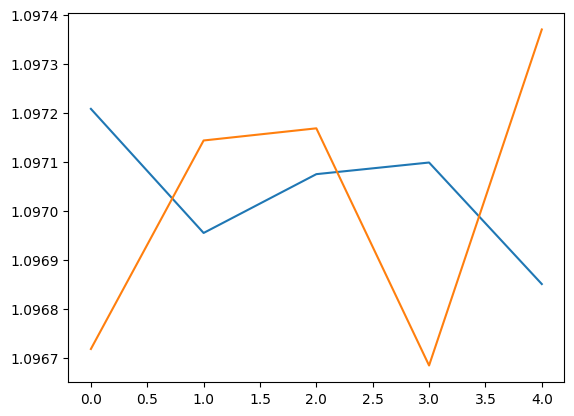

In [40]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [41]:
# print("Training the model")
# history = model.fit(x=tf_train_set, 
#           validation_data=tf_test_set,
#           epochs=1)

In [42]:
# print("Training the model")
# history = model.fit(x=tf_train_set, 
#           validation_data=tf_test_set,
#           epochs=1)

In [43]:
%%time
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = pipe(data['test']['text'])
pred_labels = [model.config.label2id[x['label']] for x in prediction]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 26min 59s, sys: 5.61 s, total: 27min 5s
Wall time: 27min 7s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.1932925381957703
Precision-Score 0.1317227008186098
Recall-Score 0.36293622141997595
accuracy_Score 0.36293622141997595


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


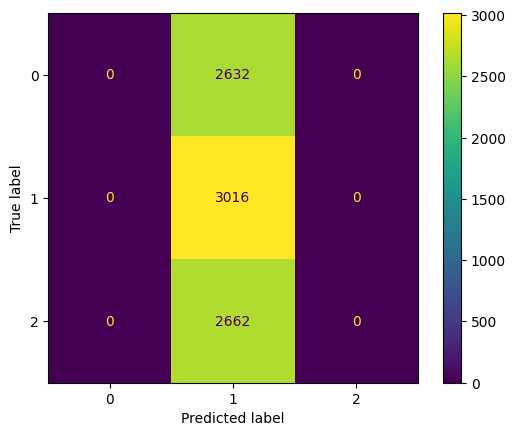

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()